This notebook was trained on Colab and we use pytorch as the deep learning framework. You can download our trained model from: 

LSTM: https://drive.google.com/file/d/1-7PTT0jIPaR5o4x0vmNkiW7mYOxM75Nn/view?usp=sharing

GRU: https://drive.google.com/file/d/1-KEePmMCQYSlQ9qZsJc_ik_Y3-YwrchY/view?usp=sharing

BERT + GRU: https://drive.google.com/file/d/1-A8Vc9GOUIqZrgBfnjESgIEfn15pjhGi/view?usp=sharing

Before using torch.load() to load the trained model, you need to run the related class first (RNN and BERTGRU class)

In [ ]:
### You don't need this if you are not running in colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/comp4332/project1/data_2021_spring

/content/drive/My Drive/comp4332/project1/data_2021_spring


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, SGD
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchtext.legacy import data
import nltk
nltk.download('punkt')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# you need to change the dir/address to yours own dir/address
# we want to keep the label and sentences in a new csv only
df_train = pd.read_csv('train.csv')
df_train = df_train[['stars','text']]
df_train.to_csv('new_train.csv', index=False)
df_valid = pd.read_csv('valid.csv')
df_valid = df_valid[['stars','text']]
df_valid.to_csv('new_valid.csv', index=False)
df_test = pd.read_csv('test.csv')
df_test = pd.DataFrame(df_test['text'])
stars = range(len(df_test))
df_test.insert(0, "stars", stars)
display(df_test)
df_test.to_csv('new_test.csv', index=False)

stars                                               text
0         0  I took the UP Train to Union Station to catch ...
1         1  We worked with Fitness with a Twist for part o...
2         2  It's your typical, average, run-of-the-mill co...
3         3  We went to Outback today to celebrate my daugh...
4         4  We Went to see Nashville unplugged a country c...
...     ...                                                ...
1995   1995  This was an ok Burger joint. This chain is big...
1996   1996  Came here on a whim as we were passing through...
1997   1997  This is my favorite Mexican food place on the ...
1998   1998  Stopped in here on 3/24/16 around 8pm when the...
1999   1999  Who knew that you could get really good Asian ...

[2000 rows x 2 columns]

#### Dataloader for LSTM & GRU

In [ ]:
label_field = data.Field(sequential=False, use_vocab=False, batch_first=True)
txt_field = data.Field(tokenize=word_tokenize, lower=True, include_lengths=True, batch_first=True)

# you need to change the dir/address to yours own dir/address
train, validation, test= data.TabularDataset.splits(path='/content/drive/My Drive/comp4332/project1/data_2021_spring', train='new_train.csv', 
                                               validation = 'new_valid.csv', test='new_test.csv',format='csv', 
                                  fields=[('label', label_field), ('sentence', txt_field)], skip_header=True)


txt_field.build_vocab(train, min_freq=3)

train_iter, valid_iter,test_iter = data.BucketIterator.splits((train, validation, test), batch_size=32, 
                                                   sort_key=lambda x: len(x.sentence),sort_within_batch=True)

In [ ]:
_, batch = next(enumerate(train_iter))# each batch = 32
# label
print('label tensor', batch.label.shape)
print(batch.label)
print()
sent, sent_len = batch.sentence #first item is sentence and the second item is the second len
print('sentence length tensor', sent_len.shape)
print(sent_len) # the len of the sentence
print()
print('sentence tensor', sent.shape)
print(sent) #30 sentences in a matrix

label tensor torch.Size([32])
tensor([4, 4, 5, 3, 4, 4, 5, 5, 5, 1, 4, 5, 5, 5, 5, 3, 5, 5, 5, 1, 5, 5, 4, 4,
        4, 5, 1, 1, 4, 5, 5, 3])

sentence length tensor torch.Size([32])
tensor([88, 88, 88, 88, 88, 88, 88, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87,
        87, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86])

sentence tensor torch.Size([32, 88])
tensor([[  21,   13,    7,  ...,   24,   85,    2],
        [  78,  842, 5322,  ..., 1281, 1227,    2],
        [   6,  112,   41,  ...,   64,   12,   12],
        ...,
        [  30,  134,    4,  ...,    2,    1,    1],
        [   6,   53, 4322,  ...,   12,    1,    1],
        [ 197,   11, 1260,  ...,    2,    1,    1]])


In [ ]:
def save_checkpoint(save_path, model):
    if save_path==None:
        return
    save_path = save_path 
    '''state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_acc': val_acc}'''

    torch.save(model, save_path+'.pt')

    print(f'Model saved to ==> {save_path}.pt')

def load_checkpoint(save_path):
    model = torch.load(save_path+'.pt')
    print(f'Model loaded from <== {save_path}.pt')
    
    return model


def TRAIN(model, train_iter, valid_iter,  num_epochs, eval_every, total_step, criterion, optimizer, val_loss, device, save_name):
    y_train_loss = []
    y_train_acc = []
    y_valid_loss = []
    y_valid_acc = []
    running_loss = 0.0
    running_corrects = 0
    running_num = 0
    global_step = 0
    best_val_acc = 0
    
    model.to(device)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        for i, batch in enumerate(train_iter):
            sent, sent_len = batch.sentence
            inputs1 = sent
            labels = batch.label
            model.train()
            inputs1 = inputs1.to(device)
            labels = labels.to(device)
            '''Training of the model'''
            # Forward pass
            outputs = model(inputs1.to(device))
            labels -= 1
            loss = criterion(outputs.to(device), labels.to(device))

            # of the last day
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            global_step += 1
            
            running_loss += loss.item()
            outputs = torch.argmax(outputs, axis=1)
            running_corrects += torch.sum(outputs == labels)
            running_num += len(labels)


            '''Evaluating the model every x steps'''
            if global_step % eval_every == 0:
                with torch.no_grad():
                    model.eval()
                    val_running_loss = 0.0
                    val_running_corrects = 0
                    for i, val_batch in enumerate(valid_iter):
                        sent, sent_len = val_batch.sentence
                        val_inputs1 = sent
                        #val_inputs2 = sent_len
                        val_labels = val_batch.label
                        val_outputs = model(val_inputs1.to(device))
                        val_labels -= 1
                        val_loss = criterion(val_outputs.to(device), val_labels.to(device))
                        val_running_loss += val_loss.item()
                        val_outputs = torch.argmax(val_outputs, axis=1)
                        val_running_corrects += torch.sum(val_outputs.to(device) == val_labels.to(device))/float(len(val_batch))
    

                    average_train_loss = running_loss / eval_every
                    average_val_loss = val_running_loss / len(valid_iter)
                    average_train_acc = running_corrects / float(running_num)
                    average_val_acc = val_running_corrects / float(len(valid_iter))
                    y_train_loss.append(average_train_loss)
                    y_train_acc.append(average_train_acc.item())
                    y_valid_loss.append(average_val_loss)
                    y_valid_acc.append(average_val_acc.item())
                    print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f},  Valid Acc: {:.4f}'
                          .format(epoch+1, num_epochs, global_step, total_step, average_train_loss,
                                  average_train_acc, average_val_loss, average_val_acc))

                    running_loss = 0.0
                    running_num = 0
                    running_corrects = 0
                    if average_val_acc > best_val_acc:
                        best_val_acc = average_val_acc
                        save_checkpoint(save_name, model)
    print('Finished Training')
    return {'train_loss': y_train_loss, 'train_acc': y_train_acc, 
            'valid_loss': y_valid_loss, 'valid_acc': y_valid_acc}

### LSTM

In [ ]:
class RNN(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout, bidirectional=False, rnn_type='LSTM'):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.emb = nn.Embedding(n_vocab, embedding_dim)#embedding layer
        self.dropout = nn.Dropout(dropout)
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(
                    input_size=embedding_dim,
                    hidden_size=n_hidden,
                    num_layers=n_layers,
                    batch_first=True,
                    bidirectional=bidirectional
            )
        else:
            self.rnn = nn.GRU(
                    input_size=embedding_dim,
                    hidden_size=n_hidden,
                    num_layers=n_layers,
                    batch_first=True,
                    bidirectional=bidirectional
            )
        if bidirectional:
            n_hidden = n_hidden*2
        self.linear = nn.Linear(n_hidden, 5)
        self.softmax = nn.Softmax()
        
    def forward(self, sent):
        sent_emb = self.emb(sent)  #batch_size, max_sent_len, embedding_dim
        sent_emb = self.dropout(sent_emb)
        outputs, hidden = self.rnn(sent_emb)
        return self.softmax(self.linear(outputs[:,-1,:]))

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

# define parameters
rnn_type = 'LSTM'
n_vocab = len(txt_field.vocab)
embedding_dim = 64
n_hidden = 128
n_layers = 1
dropout = 0.5
lr = 0.001
n_epochs = 30
eval_every = 50
total_step = len(train_iter)*n_epochs
val_loss = None
weight_decay = 5e-5

# build model
criterion = nn.CrossEntropyLoss()
LSTM = RNN(n_vocab, embedding_dim, n_hidden, n_layers, dropout, rnn_type=rnn_type).to(device)
optimizer = Adam(LSTM.parameters(), lr=lr, weight_decay=weight_decay)


save_name = 'LSTM_model' #save the model as this name
#start training
LSTM_result = TRAIN(LSTM, train_iter, valid_iter,  n_epochs, eval_every, total_step, criterion, optimizer, val_loss, device, save_name)

Current device: cuda:0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/30], Step [50/9390], Train Loss: 1.5985, Train Acc: 0.2450, Valid Loss: 1.5945,  Valid Acc: 0.2629
Model saved to ==> LSTM_model.pt
Epoch [1/30], Step [100/9390], Train Loss: 1.5950, Train Acc: 0.2512, Valid Loss: 1.6017,  Valid Acc: 0.2321
Epoch [1/30], Step [150/9390], Train Loss: 1.5906, Train Acc: 0.2556, Valid Loss: 1.5757,  Valid Acc: 0.2922
Model saved to ==> LSTM_model.pt
Epoch [1/30], Step [200/9390], Train Loss: 1.5741, Train Acc: 0.3106, Valid Loss: 1.5447,  Valid Acc: 0.3338
Model saved to ==> LSTM_model.pt
Epoch [1/30], Step [250/9390], Train Loss: 1.5696, Train Acc: 0.3012, Valid Loss: 1.5458,  Valid Acc: 0.3130
Epoch [1/30], Step [300/9390], Train Loss: 1.5523, Train Acc: 0.3150, Valid Loss: 1.5667,  Valid Acc: 0.3080
Epoch [2/30], Step [350/9390], Train Loss: 1.5732, Train Acc: 0.2929, Valid Loss: 1.5662,  Valid Acc: 0.3026
Epoch [2/30], Step [400/9390], Train Loss: 1.5785, Train Acc: 0.2756, Valid Loss: 1.5599,  Valid Acc: 0.3140
Epoch [2/30], Step [450/9390],

In [ ]:
from sklearn.metrics import classification_report
def eval(model, valid_iter):
    y_test = []
    y_pred = []
    with torch.no_grad():
        for i, batch in enumerate(valid_iter):
            sent, sent_len = batch.sentence
            inputs1 = sent
            #inputs2 = sent_len
            model.eval()
            outputs = model(inputs1.cuda())
            outputs = torch.argmax(outputs, axis=1)
            # becuase the output is from 0 to 4, but labels are 1 to 5
            labels = batch.label
            outputs += 1
            for j in range(len(labels)):
                y_pred.append(outputs[j].item())
                y_test.append(labels[j].item())
    print(classification_report(y_test, y_pred))

    accuracy = (1.0*torch.sum(torch.Tensor(y_pred) == torch.Tensor(y_test))/len(y_test)).item()
    print('Accuracy for testing set:',accuracy)

LSTM = load_checkpoint('LSTM_model')
eval(LSTM, valid_iter)

Model loaded from <== LSTM_model.pt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


              precision    recall  f1-score   support

           1       0.76      0.82      0.79       517
           2       0.40      0.28      0.33       278
           3       0.48      0.51      0.49       344
           4       0.52      0.56      0.54       427
           5       0.71      0.68      0.70       434

    accuracy                           0.61      2000
   macro avg       0.57      0.57      0.57      2000
weighted avg       0.60      0.61      0.60      2000

Accuracy for testing set: 0.6060000061988831


### GRU

In [ ]:
# define parameters
rnn_type = 'GRU'
n_vocab = len(txt_field.vocab)
embedding_dim = 64
n_hidden = 128
n_layers = 1
dropout = 0.5
lr = 0.001
n_epochs = 30
eval_every = 50
total_step = len(train_iter)*n_epochs
val_loss = None
weight_decay = 5e-5

# build model
criterion = nn.CrossEntropyLoss()
GRU = RNN(n_vocab, embedding_dim, n_hidden, n_layers, dropout, rnn_type=rnn_type).to(device)
optimizer = Adam(GRU.parameters(), lr=lr, weight_decay=weight_decay)


save_name = 'GRU_model' #save the model as this name
#start training
GRU_result = TRAIN(GRU, train_iter, valid_iter,  n_epochs, eval_every, total_step, criterion, optimizer, val_loss, device, save_name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/30], Step [50/9390], Train Loss: 1.5934, Train Acc: 0.2656, Valid Loss: 1.5887,  Valid Acc: 0.2698
Model saved to ==> GRU_model.pt
Epoch [1/30], Step [100/9390], Train Loss: 1.5873, Train Acc: 0.2837, Valid Loss: 1.5668,  Valid Acc: 0.3031
Model saved to ==> GRU_model.pt
Epoch [1/30], Step [150/9390], Train Loss: 1.5674, Train Acc: 0.2987, Valid Loss: 1.5673,  Valid Acc: 0.2659
Epoch [1/30], Step [200/9390], Train Loss: 1.5754, Train Acc: 0.2750, Valid Loss: 1.5611,  Valid Acc: 0.3065
Model saved to ==> GRU_model.pt
Epoch [1/30], Step [250/9390], Train Loss: 1.5592, Train Acc: 0.3019, Valid Loss: 1.5885,  Valid Acc: 0.2773
Epoch [1/30], Step [300/9390], Train Loss: 1.5831, Train Acc: 0.2700, Valid Loss: 1.5931,  Valid Acc: 0.2629
Epoch [2/30], Step [350/9390], Train Loss: 1.5869, Train Acc: 0.2677, Valid Loss: 1.5717,  Valid Acc: 0.3016
Epoch [2/30], Step [400/9390], Train Loss: 1.5661, Train Acc: 0.3037, Valid Loss: 1.5691,  Valid Acc: 0.3026
Epoch [2/30], Step [450/9390], Tr

In [ ]:
GRU = load_checkpoint('GRU_model')
eval(GRU, valid_iter)

Model loaded from <== GRU_model.pt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


              precision    recall  f1-score   support

           1       0.77      0.84      0.80       517
           2       0.39      0.23      0.29       278
           3       0.46      0.65      0.54       344
           4       0.58      0.47      0.52       427
           5       0.70      0.73      0.72       434

    accuracy                           0.62      2000
   macro avg       0.58      0.58      0.57      2000
weighted avg       0.61      0.62      0.61      2000

Accuracy for testing set: 0.6179999709129333


### Compare

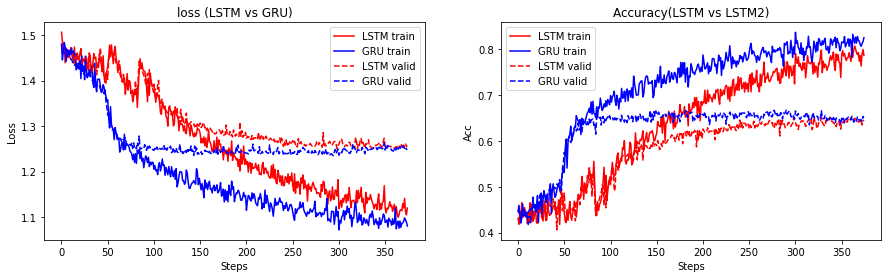

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.title('loss (LSTM vs GRU)')
plt.plot(range(len(LSTM_result['train_loss'])), LSTM_result['train_loss'], 'r', label='LSTM train')
plt.plot(range(len(GRU_result['train_loss'])), GRU_result['train_loss'], 'b', label='GRU train')
plt.plot(range(len(LSTM_result['valid_loss'])), LSTM_result['valid_loss'], 'r--', label='LSTM valid')
plt.plot(range(len(GRU_result['valid_loss'])), GRU_result['valid_loss'], 'b--', label='GRU valid')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.title('Accuracy(LSTM vs LSTM2)')
plt.plot(range(len(LSTM_result['train_acc'])), LSTM_result['train_acc'], 'r', label='LSTM train')
plt.plot(range(len(GRU_result['train_acc'])), GRU_result['train_acc'], 'b', label='GRU train')
plt.plot(range(len(LSTM_result['valid_acc'])), LSTM_result['valid_acc'], 'r--', label='LSTM valid')
plt.plot(range(len(GRU_result['valid_acc'])), GRU_result['valid_acc'], 'b--', label='GRU valid')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Acc')
#plt.savefig('LSTM1_LSTM2_Loss.png')
plt.show()

### BERT + GRU

Use pre-train BERT model to output a representitive 2-dimentional embedding. No backprop will be done on the pre-train BERT. Fit the embedding into the a GRU model and get the 5-dimensional output as prediction. Since we only do backprop on GRU model, the GPU ram on colab is sufficient for it.


* Actually this idea is from https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/6%20-%20Transformers%20for%20Sentiment%20Analysis.ipynb

* The pre-trained BERT model is from https://huggingface.co/transformers/index.html


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, SGD
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchtext.legacy import data
import nltk
nltk.download('punkt')
from nltk import word_tokenize
!pip install transformers
from transformers import BertTokenizer
from transformers import BertModel
from tqdm.notebook import tqdm
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
     |████████████████████████████████| 2.0MB 8.2MB/s 
     |████████████████████████████████| 870kB 34.6MB/s 
     |████████████████████████████████| 3.3MB 51.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=9bb6b44fd0192f0e204c385fcf99af76a6a4af4177a778cbb4fa28fd2747d417
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
Current device: cuda:0


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


In [ ]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


In [ ]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

print(max_input_length)

512


In [ ]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [ ]:
#from torchtext.legacy import data

txt_field = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

label_field = data.LabelField(dtype = torch.long, use_vocab=False)

In [ ]:
train, validation, test= data.TabularDataset.splits(path='/content/drive/My Drive/comp4332/project1/data_2021_spring', train='new_train.csv', 
                                               validation = 'new_valid.csv', test='new_test.csv',format='csv', 
                                  fields=[('label', label_field), ('sentence', txt_field)], skip_header=True)


txt_field.build_vocab(train, min_freq=3)

train_iter, valid_iter,test_iter = data.BucketIterator.splits((train, validation, test), batch_size=32, 
                                                   sort_key=lambda x: len(x.sentence),sort_within_batch=True, device=device, shuffle=True)

In [ ]:
def TRAIN_BERT(model, train_iter, valid_iter,  num_epochs, eval_every, total_step, criterion, optimizer, val_loss, device, save_name):
    y_train_loss = []
    y_train_acc = []
    y_valid_loss = []
    y_valid_acc = []
    running_loss = 0.0
    running_corrects = 0
    running_num = 0
    global_step = 0
    best_val_acc = 0
    
    model.to(device)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        for i, batch in enumerate(tqdm(train_iter)):
            model.train()
            '''Training of the model'''
            # Forward pass
            labels = batch.label
            labels -= 1
            outputs = model(batch.sentence.to(device)).squeeze(1)
            #labels = labels.long()
            loss = criterion(outputs.to(device), labels.to(device))

            # of the last day
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            global_step += 1
            
            running_loss += loss.item()
            outputs = torch.argmax(outputs, axis=1)
            running_corrects += torch.sum(outputs == labels)
            running_num += len(labels)


            '''Evaluating the model every x steps'''
            if global_step % eval_every == 0:
                with torch.no_grad():
                    model.eval()
                    val_running_loss = 0.0
                    val_running_corrects = 0
                    for i, val_batch in enumerate(valid_iter):
                        val_labels = val_batch.label
                        val_labels -= 1
                        val_outputs = model(val_batch.sentence.to(device)).squeeze(1)
                        val_loss = criterion(val_outputs.to(device), val_labels.to(device))
                        val_running_loss += val_loss.item()
                        val_outputs = torch.argmax(val_outputs, axis=1)
                        val_running_corrects += torch.sum(val_outputs == val_labels)#/float(len(val_batch))
    
                    average_train_loss = running_loss / eval_every
                    average_val_loss = val_running_loss / len(valid_iter)
                    average_train_acc = running_corrects / float(running_num)
                    average_val_acc = val_running_corrects / float(len(df_valid))
                    y_train_loss.append(average_train_loss)
                    y_train_acc.append(average_train_acc.item())
                    y_valid_loss.append(average_val_loss)
                    y_valid_acc.append(average_val_acc.item())
                    print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f},  Valid Acc: {:.4f}'
                          .format(epoch+1, num_epochs, global_step, total_step, average_train_loss,
                                  average_train_acc, average_val_loss, average_val_acc))

                    running_loss = 0.0
                    running_num = 0
                    running_corrects = 0
                    if average_val_acc > best_val_acc:
                        best_val_acc = average_val_acc
                        save_checkpoint(save_name, model)
    print('Finished Training')
    return {'train_loss': y_train_loss, 'train_acc': y_train_acc, 
            'valid_loss': y_valid_loss, 'valid_acc': y_valid_acc}

In [ ]:
# DistilBERT is a lighter and faster version of BERT
class BERTGRU(nn.Module):
    def __init__(self,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        super(BERTGRU, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        #self.model.classifier = nn.Linear(in_features=768, out_features=5)
        embedding_dim = self.bert.config.to_dict()['hidden_size']

        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, sent):
        with torch.no_grad():
            embedded = self.bert(sent)[0]
        
        _, hidden = self.rnn(embedded)
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

In [ ]:
# define parameters
lr = 0.001
n_epochs = 10
eval_every = 50
total_step = len(train_iter)*n_epochs
val_loss = None
weight_decay = 5e-4

HIDDEN_DIM = 256
OUTPUT_DIM = 5
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5

criterion = nn.CrossEntropyLoss()
BERT_GRU = load_checkpoint('BERTGRU_model1')
#BERT_GRU = BERTGRU(HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)

optimizer = Adam(BERT_GRU.parameters(), lr=lr, weight_decay=weight_decay)

save_name = 'BERTGRU_model' #save the model as this name
#start training
BERTGRU_result = TRAIN_BERT(BERT_GRU, train_iter, valid_iter,  n_epochs, eval_every, total_step, criterion, optimizer, val_loss, device, save_name)

Model loaded from <== BERTGRU_model1.pt


Epoch [1/10], Step [50/3130], Train Loss: 0.8352, Train Acc: 0.6444, Valid Loss: 0.7689,  Valid Acc: 0.6615
Model saved to ==> BERTGRU_model.pt
Epoch [1/10], Step [100/3130], Train Loss: 0.8249, Train Acc: 0.6538, Valid Loss: 0.7410,  Valid Acc: 0.6775
Model saved to ==> BERTGRU_model.pt
Epoch [1/10], Step [150/3130], Train Loss: 0.8042, Train Acc: 0.6606, Valid Loss: 0.7438,  Valid Acc: 0.6775
Epoch [1/10], Step [200/3130], Train Loss: 0.8368, Train Acc: 0.6369, Valid Loss: 0.7357,  Valid Acc: 0.6730
Epoch [1/10], Step [250/3130], Train Loss: 0.8313, Train Acc: 0.6606, Valid Loss: 0.7488,  Valid Acc: 0.6675
Epoch [1/10], Step [300/3130], Train Loss: 0.8044, Train Acc: 0.6575, Valid Loss: 0.7636,  Valid Acc: 0.6660



Epoch [2/10], Step [350/3130], Train Loss: 0.8164, Train Acc: 0.6528, Valid Loss: 0.8268,  Valid Acc: 0.6265
Epoch [2/10], Step [400/3130], Train Loss: 0.7806, Train Acc: 0.6463, Valid Loss: 0.7747,  Valid Acc: 0.6710
Epoch [2/10], Step [450/3130], Train Loss: 0.7893, Train Acc: 0.6712, Valid Loss: 0.7829,  Valid Acc: 0.6595
Epoch [2/10], Step [500/3130], Train Loss: 0.7480, Train Acc: 0.6825, Valid Loss: 0.7521,  Valid Acc: 0.6760
Epoch [2/10], Step [550/3130], Train Loss: 0.7710, Train Acc: 0.6700, Valid Loss: 0.8783,  Valid Acc: 0.6410
Epoch [2/10], Step [600/3130], Train Loss: 0.8446, Train Acc: 0.6513, Valid Loss: 0.8145,  Valid Acc: 0.6445



Epoch [3/10], Step [650/3130], Train Loss: 0.7827, Train Acc: 0.6540, Valid Loss: 0.7686,  Valid Acc: 0.6690
Epoch [3/10], Step [700/3130], Train Loss: 0.7694, Train Acc: 0.6731, Valid Loss: 0.7870,  Valid Acc: 0.6680
Epoch [3/10], Step [750/3130], Train Loss: 0.7870, Train Acc: 0.6556, Valid Loss: 0.7417,  Valid Acc: 0.6735
Epoch [3/10], Step [800/3130], Train Loss: 0.7589, Train Acc: 0.6681, Valid Loss: 0.8511,  Valid Acc: 0.6355
Epoch [3/10], Step [850/3130], Train Loss: 0.7775, Train Acc: 0.6875, Valid Loss: 0.7645,  Valid Acc: 0.6625
Epoch [3/10], Step [900/3130], Train Loss: 0.8004, Train Acc: 0.6456, Valid Loss: 0.8118,  Valid Acc: 0.6615



Epoch [4/10], Step [950/3130], Train Loss: 0.7613, Train Acc: 0.6761, Valid Loss: 0.8098,  Valid Acc: 0.6575
Epoch [4/10], Step [1000/3130], Train Loss: 0.7172, Train Acc: 0.6862, Valid Loss: 0.7698,  Valid Acc: 0.6750
Epoch [4/10], Step [1050/3130], Train Loss: 0.7164, Train Acc: 0.6981, Valid Loss: 0.7959,  Valid Acc: 0.6490
Epoch [4/10], Step [1100/3130], Train Loss: 0.7683, Train Acc: 0.6687, Valid Loss: 0.7643,  Valid Acc: 0.6825
Model saved to ==> BERTGRU_model.pt
Epoch [4/10], Step [1150/3130], Train Loss: 0.7526, Train Acc: 0.6781, Valid Loss: 0.7541,  Valid Acc: 0.6685
Epoch [4/10], Step [1200/3130], Train Loss: 0.7488, Train Acc: 0.6750, Valid Loss: 0.7606,  Valid Acc: 0.6750
Epoch [4/10], Step [1250/3130], Train Loss: 0.7476, Train Acc: 0.6755, Valid Loss: 0.9022,  Valid Acc: 0.6470



Epoch [5/10], Step [1300/3130], Train Loss: 0.6972, Train Acc: 0.6975, Valid Loss: 0.7745,  Valid Acc: 0.6815
Epoch [5/10], Step [1350/3130], Train Loss: 0.7021, Train Acc: 0.6944, Valid Loss: 0.7808,  Valid Acc: 0.6520
Epoch [5/10], Step [1400/3130], Train Loss: 0.7601, Train Acc: 0.6812, Valid Loss: 0.7607,  Valid Acc: 0.6630
Epoch [5/10], Step [1450/3130], Train Loss: 0.6956, Train Acc: 0.7181, Valid Loss: 0.8794,  Valid Acc: 0.6370
Epoch [5/10], Step [1500/3130], Train Loss: 0.7180, Train Acc: 0.6950, Valid Loss: 0.7859,  Valid Acc: 0.6695
Epoch [5/10], Step [1550/3130], Train Loss: 0.7129, Train Acc: 0.6894, Valid Loss: 0.7936,  Valid Acc: 0.6535



Epoch [6/10], Step [1600/3130], Train Loss: 0.6802, Train Acc: 0.7052, Valid Loss: 0.8314,  Valid Acc: 0.6600
Epoch [6/10], Step [1650/3130], Train Loss: 0.7091, Train Acc: 0.7012, Valid Loss: 0.8415,  Valid Acc: 0.6530
Epoch [6/10], Step [1700/3130], Train Loss: 0.7129, Train Acc: 0.6956, Valid Loss: 0.8171,  Valid Acc: 0.6615
Epoch [6/10], Step [1750/3130], Train Loss: 0.7070, Train Acc: 0.6912, Valid Loss: 0.7809,  Valid Acc: 0.6640
Epoch [6/10], Step [1800/3130], Train Loss: 0.6854, Train Acc: 0.7106, Valid Loss: 0.7839,  Valid Acc: 0.6645
Epoch [6/10], Step [1850/3130], Train Loss: 0.7040, Train Acc: 0.6981, Valid Loss: 0.8744,  Valid Acc: 0.6135



Epoch [7/10], Step [1900/3130], Train Loss: 0.6886, Train Acc: 0.7083, Valid Loss: 0.7873,  Valid Acc: 0.6765
Epoch [7/10], Step [1950/3130], Train Loss: 0.6181, Train Acc: 0.7331, Valid Loss: 0.8203,  Valid Acc: 0.6655
Epoch [7/10], Step [2000/3130], Train Loss: 0.6983, Train Acc: 0.7069, Valid Loss: 0.8498,  Valid Acc: 0.6345
Epoch [7/10], Step [2050/3130], Train Loss: 0.6738, Train Acc: 0.7100, Valid Loss: 0.8513,  Valid Acc: 0.6540
Epoch [7/10], Step [2100/3130], Train Loss: 0.6954, Train Acc: 0.7075, Valid Loss: 0.8067,  Valid Acc: 0.6615
Epoch [7/10], Step [2150/3130], Train Loss: 0.6599, Train Acc: 0.7175, Valid Loss: 0.8784,  Valid Acc: 0.6290



Epoch [8/10], Step [2200/3130], Train Loss: 0.6659, Train Acc: 0.7229, Valid Loss: 0.7972,  Valid Acc: 0.6675
Epoch [8/10], Step [2250/3130], Train Loss: 0.6181, Train Acc: 0.7387, Valid Loss: 0.8280,  Valid Acc: 0.6660
Epoch [8/10], Step [2300/3130], Train Loss: 0.6040, Train Acc: 0.7462, Valid Loss: 0.8438,  Valid Acc: 0.6745
Epoch [8/10], Step [2350/3130], Train Loss: 0.6294, Train Acc: 0.7331, Valid Loss: 0.8265,  Valid Acc: 0.6650
Epoch [8/10], Step [2400/3130], Train Loss: 0.6138, Train Acc: 0.7362, Valid Loss: 0.8537,  Valid Acc: 0.6635
Epoch [8/10], Step [2450/3130], Train Loss: 0.6718, Train Acc: 0.7194, Valid Loss: 0.9245,  Valid Acc: 0.6120
Epoch [8/10], Step [2500/3130], Train Loss: 0.6807, Train Acc: 0.7077, Valid Loss: 0.8337,  Valid Acc: 0.6610



Epoch [9/10], Step [2550/3130], Train Loss: 0.5707, Train Acc: 0.7544, Valid Loss: 0.8697,  Valid Acc: 0.6525
Epoch [9/10], Step [2600/3130], Train Loss: 0.5574, Train Acc: 0.7650, Valid Loss: 0.8973,  Valid Acc: 0.6560
Epoch [9/10], Step [2650/3130], Train Loss: 0.6239, Train Acc: 0.7212, Valid Loss: 0.9155,  Valid Acc: 0.6355
Epoch [9/10], Step [2700/3130], Train Loss: 0.6478, Train Acc: 0.7225, Valid Loss: 0.8608,  Valid Acc: 0.6540
Epoch [9/10], Step [2750/3130], Train Loss: 0.6163, Train Acc: 0.7444, Valid Loss: 0.9026,  Valid Acc: 0.6455
Epoch [9/10], Step [2800/3130], Train Loss: 0.6579, Train Acc: 0.7212, Valid Loss: 0.8644,  Valid Acc: 0.6330



Epoch [10/10], Step [2850/3130], Train Loss: 0.5554, Train Acc: 0.7734, Valid Loss: 0.9042,  Valid Acc: 0.6425
Epoch [10/10], Step [2900/3130], Train Loss: 0.5309, Train Acc: 0.7794, Valid Loss: 0.8992,  Valid Acc: 0.6490
Epoch [10/10], Step [2950/3130], Train Loss: 0.5622, Train Acc: 0.7556, Valid Loss: 0.9055,  Valid Acc: 0.6565
Epoch [10/10], Step [3000/3130], Train Loss: 0.5916, Train Acc: 0.7469, Valid Loss: 0.9077,  Valid Acc: 0.6590
Epoch [10/10], Step [3050/3130], Train Loss: 0.6249, Train Acc: 0.7331, Valid Loss: 0.9775,  Valid Acc: 0.6335


In [17]:
from sklearn.metrics import classification_report
def eval2(model, valid_iter):
    y_test = []
    y_pred = []
    with torch.no_grad():
        for i, batch in enumerate(valid_iter):
            #inputs2 = sent_len
            model.eval()
            outputs = model(batch.sentence.to(device)).squeeze(1)
            outputs = torch.argmax(outputs, axis=1)
            # becuase the output is from 0 to 4, but labels are 1 to 5
            labels = batch.label
            outputs += 1
            for j in range(len(labels)):
                y_pred.append(outputs[j].item())
                y_test.append(labels[j].item())
    print(classification_report(y_test, y_pred))

    accuracy = (1.0*torch.sum(torch.Tensor(y_pred) == torch.Tensor(y_test))/len(y_test)).item()
    print('Accuracy for valid set:',accuracy)

BERT_GRU = load_checkpoint('BERTGRU_model')
eval2(BERT_GRU.to(device), valid_iter)

Model loaded from <== BERTGRU_model.pt
              precision    recall  f1-score   support

           1       0.80      0.86      0.83       517
           2       0.49      0.42      0.45       278
           3       0.61      0.55      0.58       344
           4       0.59      0.83      0.69       427
           5       0.89      0.59      0.71       434

    accuracy                           0.68      2000
   macro avg       0.68      0.65      0.65      2000
weighted avg       0.70      0.68      0.68      2000

Accuracy for valid set: 0.6825000047683716


### Compare

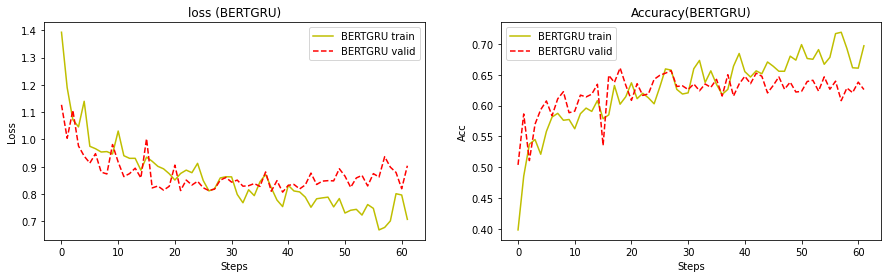

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.title('loss (BERTGRU)')
plt.plot(range(len(BERTGRU_result['train_loss'])), BERTGRU_result['train_loss'], 'y', label='BERTGRU train')
plt.plot(range(len(BERTGRU_result['valid_loss'])), BERTGRU_result['valid_loss'], 'r--', label='BERTGRU valid')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.title('Accuracy(BERTGRU)')
plt.plot(range(len(BERTGRU_result['train_acc'])), BERTGRU_result['train_acc'], 'y', label='BERTGRU train')
plt.plot(range(len(BERTGRU_result['valid_acc'])), BERTGRU_result['valid_acc'], 'r--', label='BERTGRU valid')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Acc')
#plt.savefig('LSTM1_LSTM2_Loss.png')
plt.show()

### Testing

The valid accuracy of BERT + GRU is higher, so we choose it to do prediction on testing data

In [ ]:
BERT_GRU = load_checkpoint('BERTGRU_model')

Model loaded from <== BERTGRU_model.pt


In [ ]:
_, batch = next(enumerate(valid_iter))

In [ ]:
### see shuffle or not
print(batch.label)

tensor([4, 5, 5, 1, 5, 5, 5, 1, 5, 5, 4, 5, 2, 3, 5, 5, 1, 5, 4, 5, 4, 3, 2, 4,
        5, 3, 3, 4, 5, 4, 4, 4], device='cuda:0')


In [18]:
def test(model, test_iter):
    y_test = []
    y_pred = []
    with torch.no_grad():
        for i, batch in enumerate(test_iter):
            #inputs2 = sent_len
            model.eval()
            outputs = model(batch.sentence.to(device)).squeeze(1)
            outputs = torch.argmax(outputs, axis=1)
            # becuase the output is from 0 to 4, but labels are 1 to 5
            labels = batch.label
            outputs += 1
            for j in range(len(labels)):
                y_pred.append(outputs[j].item())
                y_test.append(labels[j].item())
    return [y_test, y_pred]

result = test(BERT_GRU.to(device), test_iter)

In [19]:
df_result = pd.DataFrame(np.array(result).T, columns=['index', 'stars'])
df_result = df_result.sort_values(by=['index'])
df_result = df_result.reset_index(drop=True)
df_test = pd.read_csv('test.csv')
df_test = pd.concat([df_test['review_id'], df_result['stars']], axis=1)

In [21]:
df_test.to_csv('pred.csv', index=False)

In [ ]:
df_test

review_id  stars
0     b8-ELBwhmDKcmcM8icT86g      3
1     rBpAJhIen_V-zLoXZIcROg      5
2     _pALaDG6se9OTkGGhyhnNA      3
3     ru8fpA1Uk0tTFtO5hLM49g      1
4     fRPgwuFoY6SriToXZyaOQA      1
...                      ...    ...
1995  oZxqo6rspUimmoqKl0_qdA      4
1996  C_oCpNq91uTtOYUs2cChdg      4
1997  qMrxDB5fm8wIzexUp643xQ      5
1998  HrejfPp6Xduy5Pv7i-is1A      5
1999  cXo09g5VbXvLHtg52wqhdg      4

[2000 rows x 2 columns]